<a href="https://colab.research.google.com/github/jevylux/pytorchtraining/blob/main/ReplicateNonLinearActivationFunctions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# import tools
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


# set the device to cuda
device = "cuda"



In [36]:
# create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

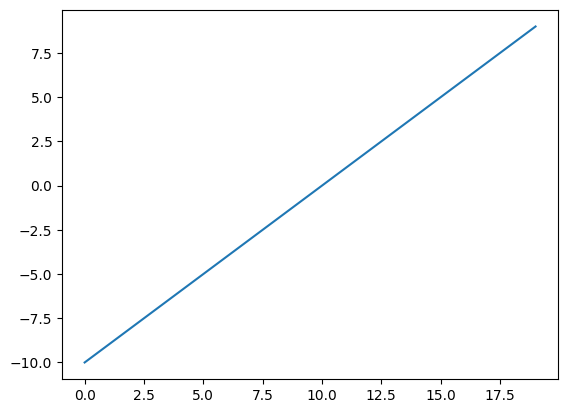

In [37]:
# visualize data
plt.plot(A)


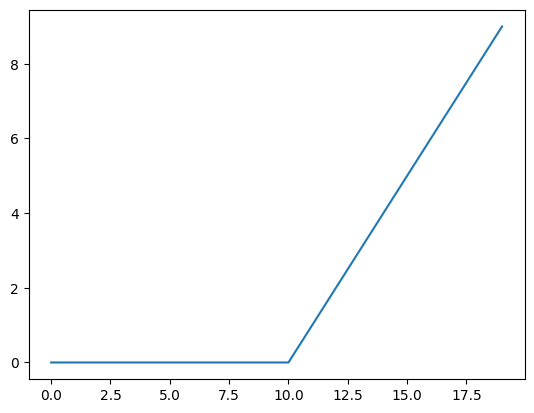

In [38]:
# plot the relu function
plt.plot(torch.relu(A))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])


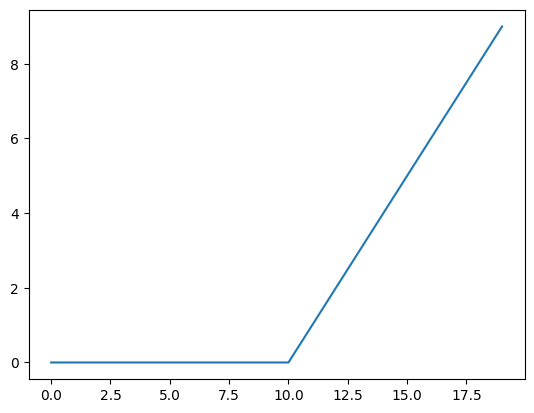

In [39]:
# define our own relu function
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # input must be tensors, and we check the maximum of 0 and value x. if value x less than 0, the max imum is 0
print(relu(A))
plt.plot(relu(A))

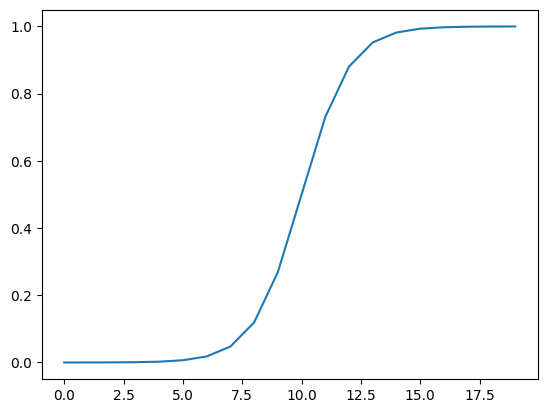

In [40]:
# sigmoid function = 1/(1+exp(-x))
def sigmoid(x):
  return 1/(1+torch.exp(-x))
# plot original sigmoid function
plt.plot(torch.sigmoid(A))


ours


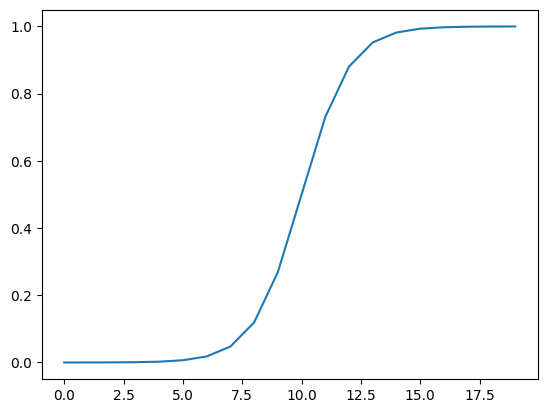

In [41]:
# plot our function
print("ours")
plt.plot(sigmoid(A))

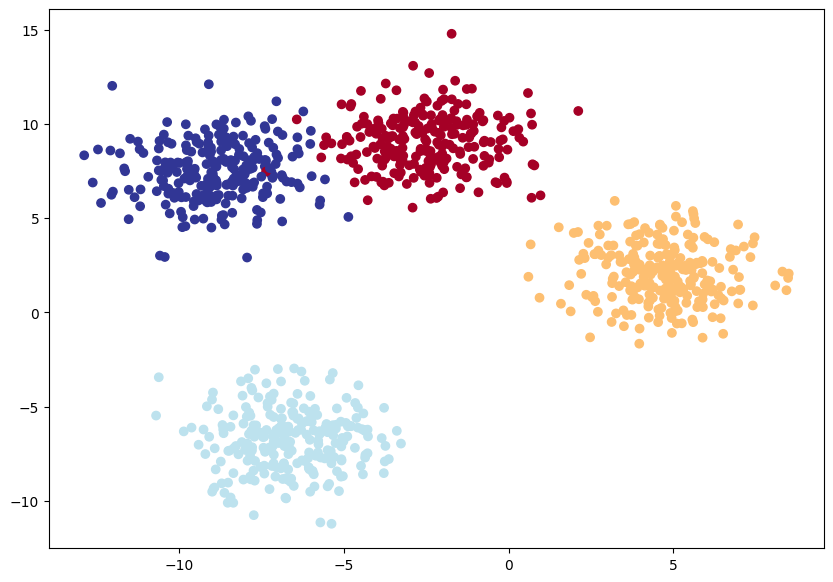

In [42]:
# putting it all together with a multi-class classification problem ( ie my spider robot)
# binary classification : one thing or another ( cat vs dog, dpsm vs not spam, fraud not fraud)
# multiclass classification = more than one thing or another ( cat vs dog, vs chicken, position of all motors for one move)
# creating a toy multi-class dataset

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# create multiclass data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state = RANDOM_SEED)

# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size = 0.2,
                                                                        random_state = RANDOM_SEED)
# plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [43]:
# Building a multicalss classification model in PyTorch
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):  # the following docstring is based on https://google.github.io/styleguide/pyguide.html
    """Initializes multi_class classification model.
      Args:
        input_features (int): Number of input features to the model
        output_features (int): Number of output features ( output classes)
        hidden_units (int): number of hidden layers, defaulzts to 8

      Returns:
      Example:
        """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features=input_features, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=output_features)
      )

  def forward(self, x):
    return self.linear_layer_stack(x)

# create model and send it to the target device
model1 = BlobModel(input_features =2,
                   output_features = 4,
                   hidden_units = 8).to(device)
print(model1)

cuda
BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [44]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [45]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [46]:
# create a loss function and an optimizer for a multi-class classification
loss_fn = nn.CrossEntropyLoss()
# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr = 0.1) # learning rate is a hyperparameter ou can change
# getting prediction probabilities for a multi-class PyTorch model
model1.eval()
with torch.inference_mode():
  y_logits = model1(X_blob_test.to(device))

y_logits[:10]


tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950],
        [-0.3673, -0.0935,  0.5180, -0.5787],
        [-0.3457,  0.2076,  0.1297, -0.9071],
        [ 0.1158, -0.1460,  0.1752, -0.1939],
        [-0.4845,  0.2289,  0.1336, -1.1274],
        [ 0.1284, -0.1145,  0.1691, -0.1944]], device='cuda:0')

In [47]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [48]:
# cnvert our models logit outputs to prediction probabilities
# Logits ( eaw output of the model) -> Pred probs ( use torch.softmax )n -> Pred labels
y_pred_probs = torch.softmax(y_logits, dim = 1)
print(y_logits[:5])
print(y_pred_probs[:5])

print(torch.sum(y_pred_probs[0]))


y_preds =torch.argmax(y_pred_probs, dim=1)
print(y_preds )


tensor([[ 0.2519,  0.2797, -0.0558, -0.2690],
        [-0.2217, -0.1392,  0.4193, -0.4493],
        [-0.3817,  0.2051,  0.1333, -0.9696],
        [ 0.2566,  0.3394, -0.1508, -0.3086],
        [ 0.1458, -0.0711,  0.1607, -0.1950]], device='cuda:0')
tensor([[0.2979, 0.3062, 0.2190, 0.1769],
        [0.2092, 0.2272, 0.3971, 0.1666],
        [0.1989, 0.3577, 0.3329, 0.1105],
        [0.3012, 0.3272, 0.2004, 0.1712],
        [0.2832, 0.2280, 0.2874, 0.2014]], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2,
        1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2,
        1, 2, 2,

In [49]:
# create a training and test loop for a multi-class PyTorch model
# fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 100

# put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device) , y_blob_train.to(device)
X_blob_tests, y_blob_test = X_blob_test.to(device) , y_blob_test.to(device)

# loop through data
# training
for epoch in range(epochs):
  model1.train()
  y_logits = model1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim =1).argmax(dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred = y_pred)

  optimzer.zero_grad()
  loss.backward()
  optimizer.step()
# test
  model1.eval()
  with torch.inference_mode():
    test_logits = model1(X_nlob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(deim = 1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = y_pred)

    # print out wahts happening

    if epohc % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")




NameError: name 'accuracy_fn' is not defined